In [1]:
%%time
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import random

np.set_printoptions(precision=4, suppress=True)

os.environ["KERAS_BACKEND"] = "tensorflow"


def clean_session():
    tf.keras.backend.clear_session()
    seed_value = 42

    os.environ['PYTHONHASHSEED'] = str(seed_value)

    random.seed(seed_value)

    np.random.seed(seed_value)

    tf.random.set_seed(seed_value)
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


def plot_results(x_testing, t_testing, t_predictions):
    fig2, ax2 = plt.subplots(1, 2)
    fig2.set_size_inches(11, 5)

    ax2[0].scatter(x_testing[t_testing == 0, 0], x_testing[t_testing == 0, 1], c="#a49d78", marker='x', label='Class 0')
    ax2[0].scatter(x_testing[t_testing == 1, 0], x_testing[t_testing == 1, 1], c="#1f3e6e", marker='o', label='Class 1')

    ax2[0].format_coord = lambda x, y: f'x1={x:.2f}, x2={y:.2f}'

    ax2[0].set_title(r'Test Data')
    ax2[0].set_xlabel('$x_1$')
    ax2[0].set_ylabel('$x_2$', rotation=0)
    ax2[0].legend()
    ax2[0].grid(True)

    ax2[1].scatter(x_testing[t_predictions == 0, 0], x_testing[t_predictions == 0, 1], c="#a49d78", marker='x',
                   label='Class 0')
    ax2[1].scatter(x_testing[t_predictions == 1, 0], x_testing[t_predictions == 1, 1], c="#1f3e6e", marker='o',
                   label='Class 1')

    ax2[1].format_coord = lambda x, y: f'x1={x:.2f}, x2={y:.2f}'

    ax2[1].set_title(r'Classification')
    ax2[1].set_xlabel('$x_1$')
    ax2[1].set_ylabel('$x_2$', rotation=0)
    ax2[1].legend()
    ax2[1].grid(True)


def plot_data(X, t, title, is_3d=False):
    c1 = "#a49d78"
    c0 = "#1f3e6e"
    if is_3d:
        fig = plt.figure()
        ax1 = fig.add_subplot(projection='3d')
        ax1.scatter(X[t == 0, 0], X[t == 0, 1], t[t == 0], c=c1, marker='o', label='Class 1')
        ax1.scatter(X[t == 1, 0], X[t == 1, 1], t[t == 1], c=c0, marker='x', label='Class 0')
    else:
        fig1, ax1 = plt.subplots()
        fig1.set_size_inches(5, 5)
        ax1.scatter(X[t == 0, 0], X[t == 0, 1], c=c1, marker='o', label='Class 1')
        ax1.scatter(X[t == 1, 0], X[t == 1, 1], c=c0, marker='x', label='Class 0')

    ax1.format_coord = lambda x, y: f'x1={x:.2f}, x2={y:.2f}'
    ax1.set_title(title)
    ax1.set_xlabel('$x_1$')
    ax1.set_ylabel('$x_2$', rotation=0)
    ax1.legend()
    ax1.grid(True)



CPU times: user 1.73 s, sys: 396 ms, total: 2.12 s
Wall time: 3.28 s


In [2]:
N = 5000  # households with at least 2 kids

import pandas as pd

data = 'data'

census_data = pd.read_csv(os.path.join(data, 'usa_00001.csv'))
census_data = census_data.sort_values(by=['CLUSTER', 'AGE'])
count = 0
families = dict()
max_age = 18


def gather(row):
    global count, families, N
    key = int(row['CLUSTER'])
    age = int(row['AGE'])
    info = families.get(key, [])
    if len(info) == 0 and count > N:
        return []
    if len(info) == 1:
        count = count + 1
    if age < max_age:
        info.append({
            'SEX': int(row['SEX'] - 1),
            'AGE': age,
        })
        families[key] = info
    return []


_ = census_data.apply(lambda row: gather(row), axis=1)


In [3]:
# look at sibling pairs
gap = 4
groups = list(filter(lambda x: len(x) >= 2, families.values()))
from itertools import combinations

ages_by_household = [list(combinations([kid['AGE'] for kid in group], 2)) for group in groups]
pairs = [item for sublist in ages_by_household for item in sublist]
np_pairs = np.array(pairs, dtype=int)
X = np_pairs
y = ((np_pairs[:, 1] - np_pairs[:, 0]) >= gap).astype(int)


In [4]:
def train(X, y, model, params):
    p = {
        "epochs": 500,
        "verbose": 0,
        "optimizer": tf.keras.optimizers.Adam(),
        "loss": tf.keras.losses.MeanSquaredError(),
        "metrics": [tf.keras.metrics.BinaryAccuracy()],
        "callbacks": []
    }
    for key, value in params.items():
        p[key] = value

    plot_data(X, y, 'data')
    plot_data(X, y, 'data', True)

    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    # ax.scatter(X[:, 0], X[:, 1], y)
    model.compile(optimizer=p["optimizer"], loss=p["loss"], metrics=p["metrics"])
    model.summary()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    clean_session()

    print('\n', ' Beginning training... ', '\n')
    history = model.fit(X_train, y_train, epochs=p["epochs"], verbose=p["verbose"], callbacks=p["callbacks"])
    print('\n', ' Training complete!', '\n')
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=p["verbose"])
    print('\n', f'Test loss: {"{:.2%}".format(test_loss)}')
    print('\n', f'Test accuracy: {"{:.2%}".format(test_acc)}')

    probability_model_output = model.predict(X_test)
    probabilities = np.hstack((1 - probability_model_output, probability_model_output))
    t_predictions = np.argmax(probabilities, 1)
    plot_results(X_test, y_test, t_predictions)

    plot_data(X_test, t_predictions, 'test', True)
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    # # ax.scatter(X_test[:, 0], X_test[:, 1], t_predictions)
    # # print(X_test[t_predictions == 0])
    # ax.scatter(X_test[t_predictions == 0, 0], X_test[t_predictions == 0, 1], t_predictions[t_predictions == 0], c="#a49d78", marker='o', label='Class 1')
    # ax.scatter(X_test[t_predictions == 1, 0], X_test[t_predictions == 1, 1], t_predictions[t_predictions == 1], c="#1f3e6e", marker='x', label='Class 0')

    model.compile(optimizer=p["optimizer"], loss=p["loss"], metrics=p["metrics"])
    model.summary()

    plt.figure(figsize=(8, 8))
    for key in history.history.keys():
        for index, item in enumerate(["loss", "accuracy"], start=1):
            if item in key:
                plt.plot(history.history[key], label=item)

    plt.legend(loc='upper right')
    plt.title('accuracy and loss')
    plt.xlabel('epoch')
    plt.ylim([0, 1])
    plt.show()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)


  Beginning training...  


  Training complete! 


 Test loss: 11.43%

 Test accuracy: 87.07%
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11 (48.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8 (36.00 B)

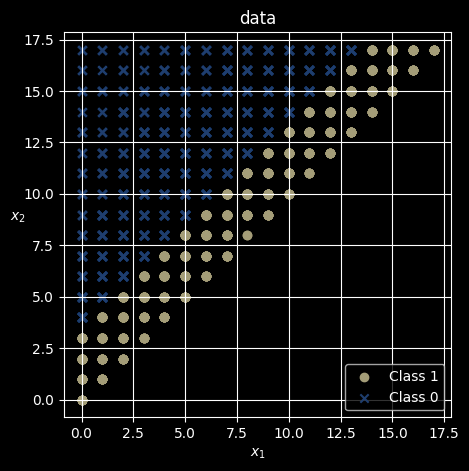

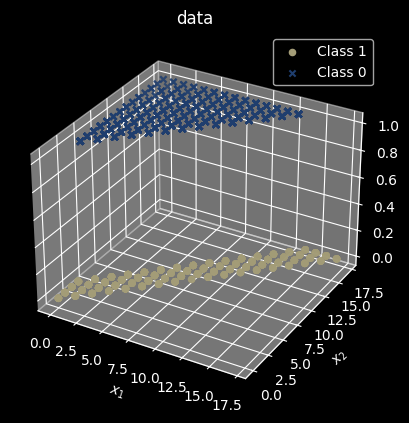

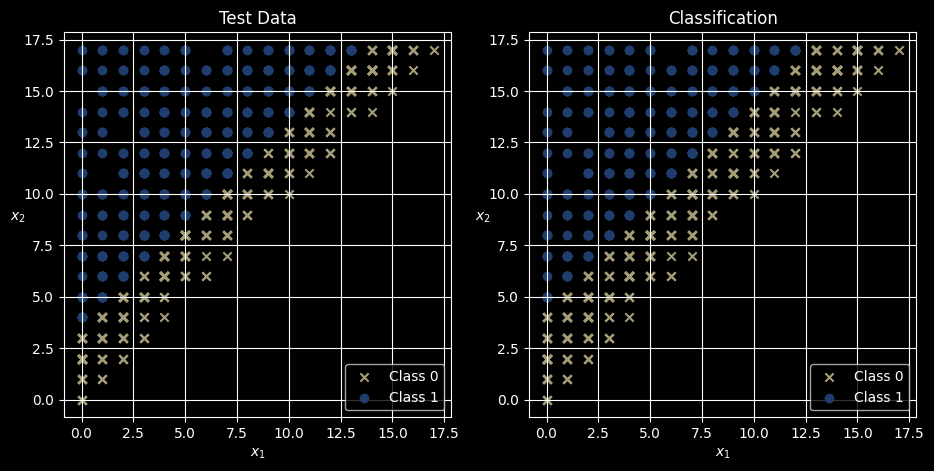

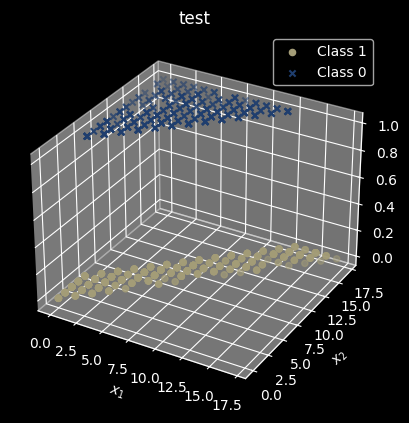

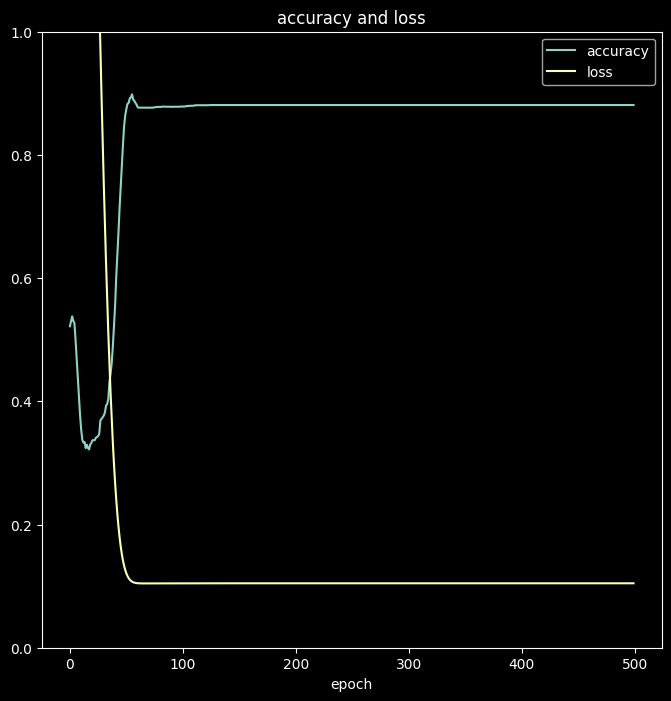

In [5]:
clean_session()
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),  # Define input shape
    tf.keras.layers.Dense(1, activation='linear')  # Direct output layer
])

params = {}

train(X, y, model, params)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)


  Beginning training...  


  Training complete! 


 Test loss: 11.39%

 Test accuracy: 87.07%
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11 (48.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8 (36.00 B)

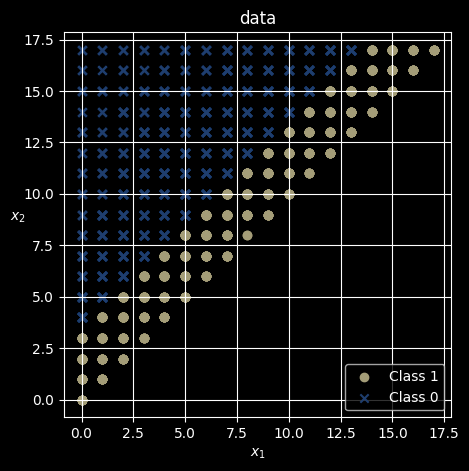

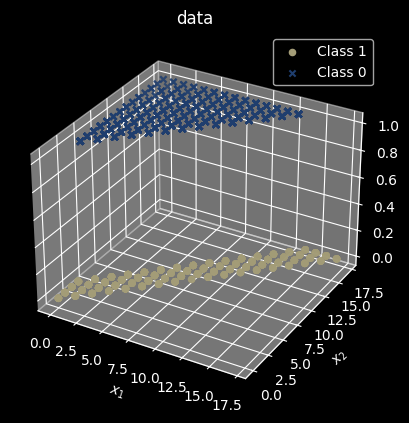

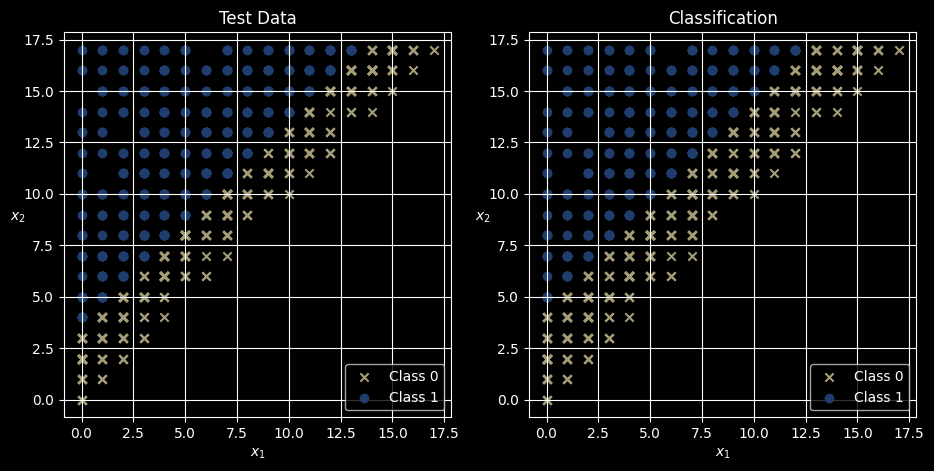

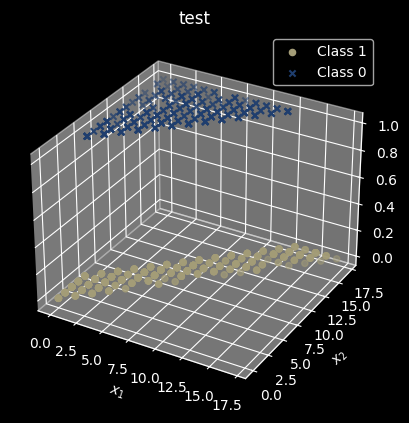

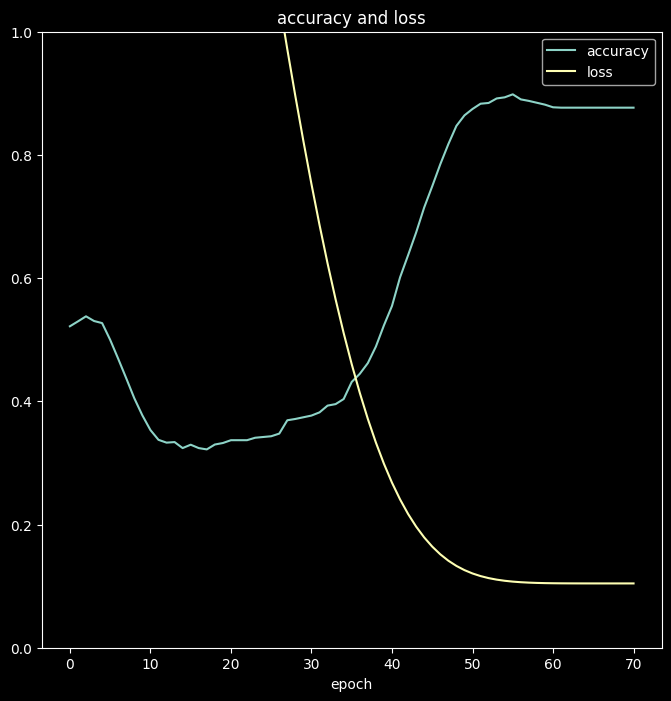

In [6]:
clean_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),  # Define input shape
    tf.keras.layers.Dense(1, activation='linear')  # Direct output layer
])

params = {
    "callbacks": [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
}

train(X, y, model, params)


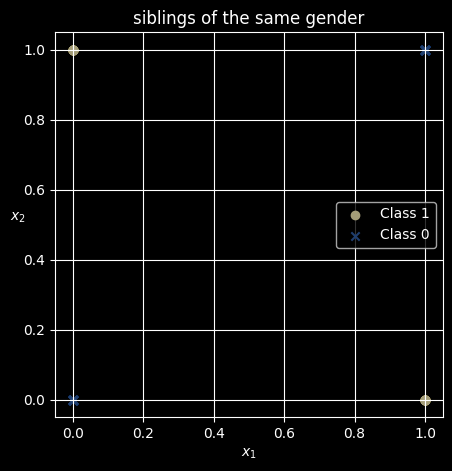

In [7]:
genders_by_household = [list(combinations([kid['SEX'] for kid in group], 2)) for group in groups]
pairs = [item for sublist in genders_by_household for item in sublist]
np_pairs = np.array(pairs, dtype=float)
y = (np_pairs[:, 1] == np_pairs[:, 0]).astype(int)
X = np_pairs

plot_data(X, y, 'siblings of the same gender')

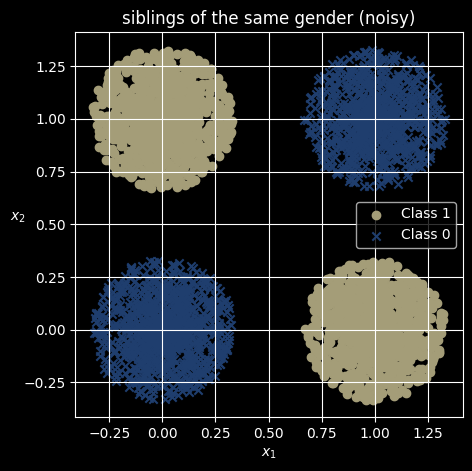

In [8]:
count = np_pairs.shape[0]
theta = 2 * np.pi * np.random.random_sample(count)
unit = np.vstack((np.cos(theta), np.sin(theta))).T
radius = np.random.rand(count).reshape(-1, 1)
X = np_pairs + unit * radius / 3.0
plot_data(X, y, 'siblings of the same gender (noisy)')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)


  Beginning training...  


  Training complete! 


 Test loss: 24.80%

 Test accuracy: 33.41%
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11 (48.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8 (36.00 B)

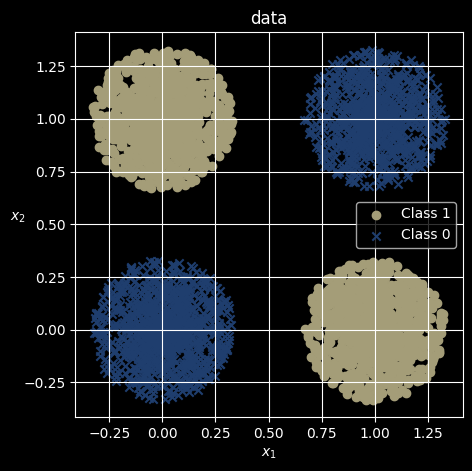

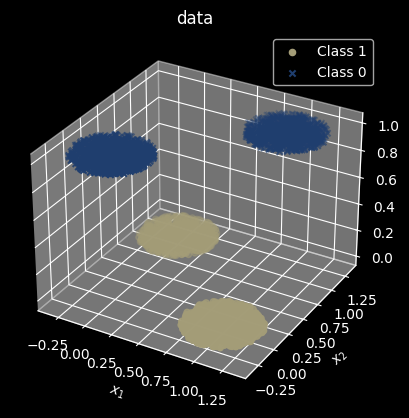

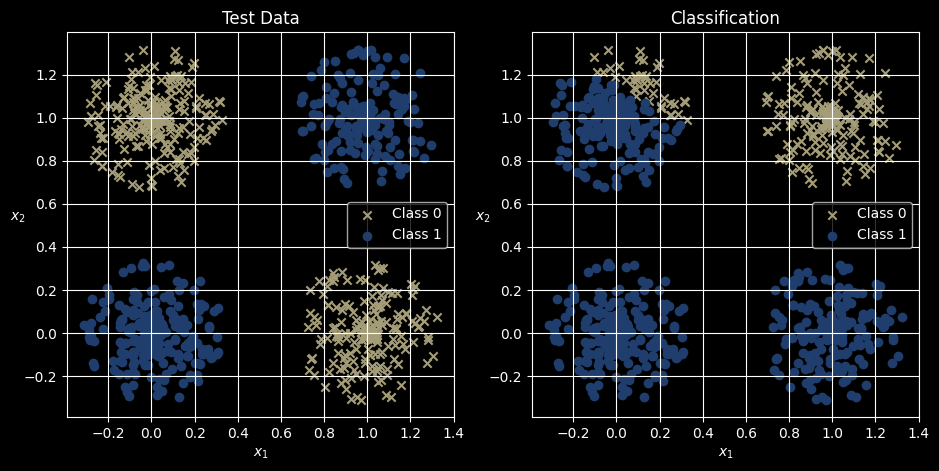

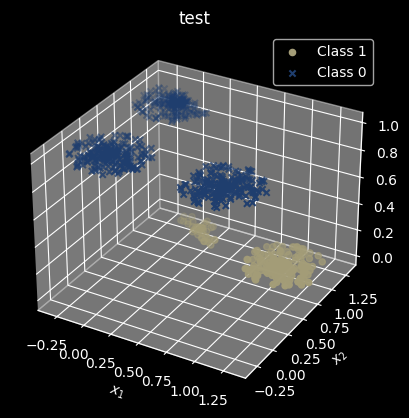

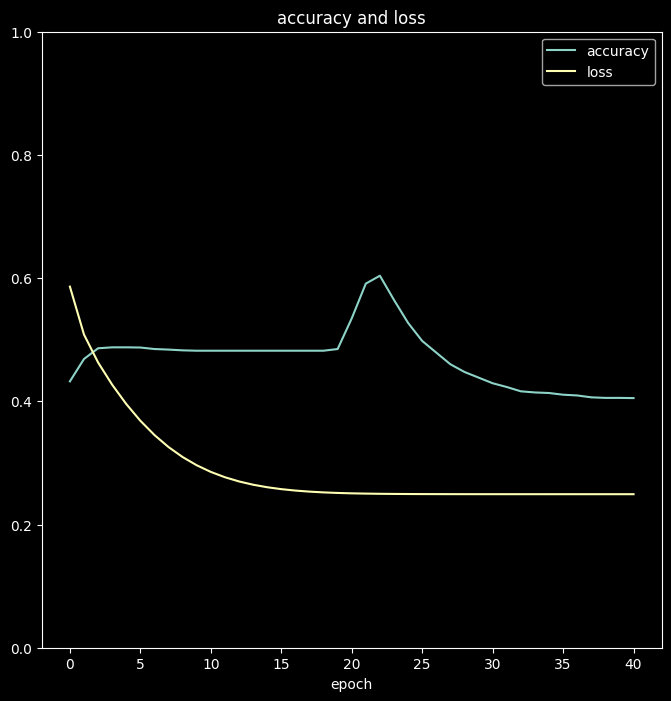

In [9]:
clean_session()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),  # Define input shape
    tf.keras.layers.Dense(1, activation='linear')  # Direct output layer
])

params = {
    "callbacks": [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
}
train(X, y, model, params)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)


  Beginning training...  


  Training complete! 


 Test loss: 0.30%

 Test accuracy: 100.00%
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53 (216.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36 (148.00 B)

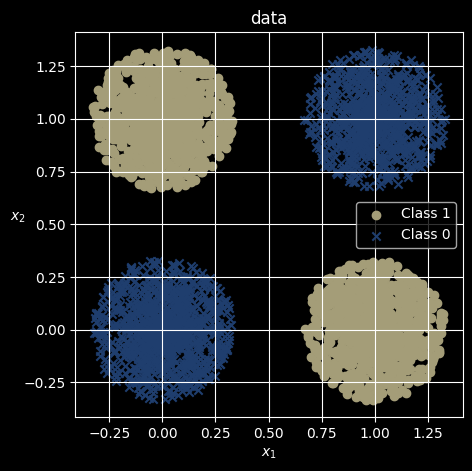

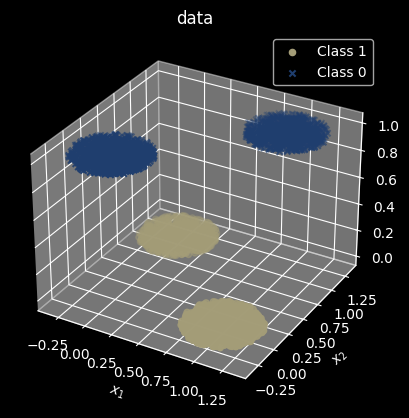

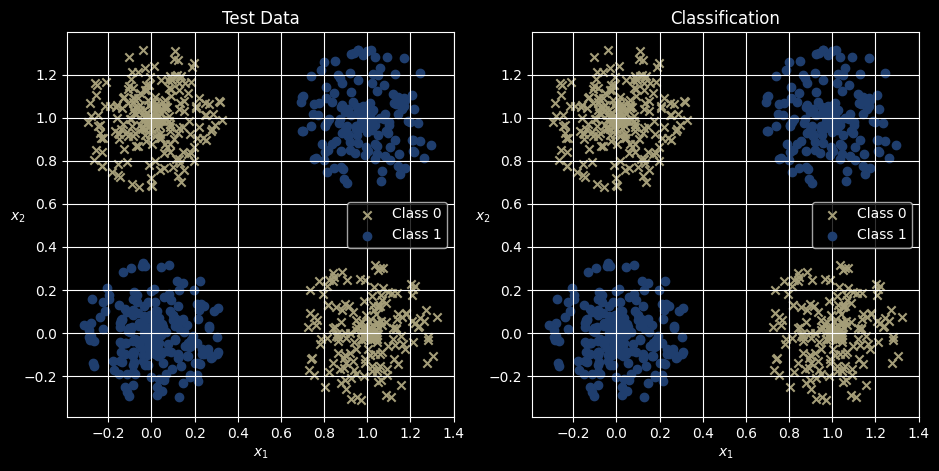

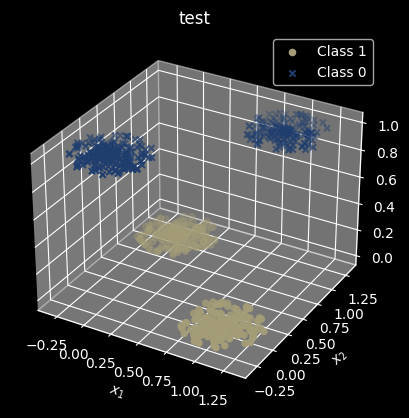

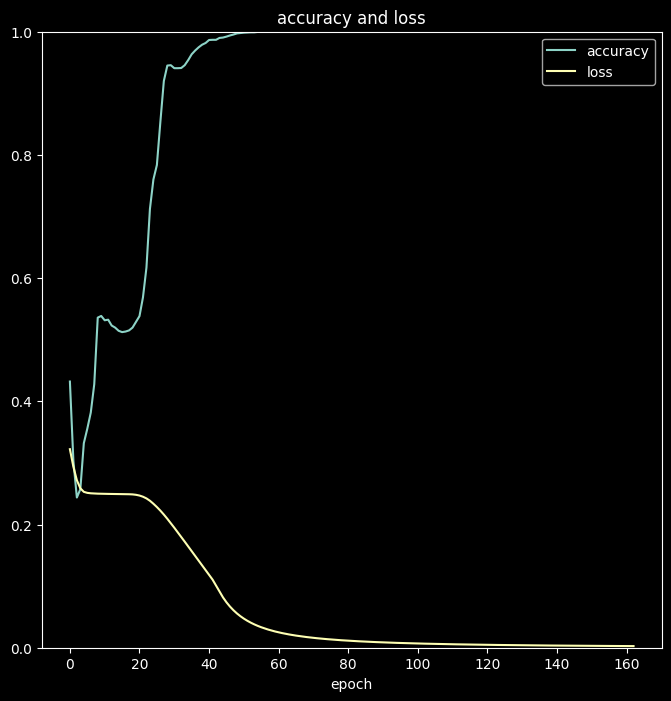

In [10]:
clean_session()

model = keras.Sequential([
    tf.keras.layers.Input((2,)),
    tf.keras.layers.Dense(units=4, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
])

params = {
    "callbacks": [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0001)],
    "verbose": 0
}
train(X, y, model, params)
